# Analysis the measures of risk factors clustering
## Workflow: executar após notebook 03_extracao_metricas_fatores_risco

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas import CategoricalDtype
from sklearn.metrics import silhouette_samples
from util import centimeter_to_inch, get_default_colors_categorical_seaborn

## General parameters


In [2]:
k_minimo = 2
k_maximo = 10

## Loading data

In [3]:
df_dataset = pd.read_csv('data/df_pca_risk_factors.csv', index_col=0)

df_y = pd.read_csv('data/df_clustering_risk_factors.csv', index_col=0)

df_metricas = pd.read_csv('data/df_risk_factor_measures.csv', index_col=0)

df_base = pd.read_csv('data/df_sociodemographic_covid.csv', index_col=0)
df_base = df_base.loc[df_dataset.index]
df_base = pd.merge(df_base, df_dataset, how='left', left_index=True, right_index=True)

In [4]:
df_base

,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,ESTADO,CODIGO_MUNICIPIO_7,POPULACAO_ESTIMADA,...,NIVEL_TAXA_OBITOS_PRIMEIRO_SEMESTRE_2020,NIVEL_LABEL_TAXA_OBITOS_PRIMEIRO_SEMESTRE_2020,NIVEL_TAXA_OBITOS_2020,NIVEL_LABEL_TAXA_OBITOS_2020,NIVEL_TAXA_OBITOS_2021,NIVEL_LABEL_TAXA_OBITOS_2021,NIVEL_TAXA_OBITOS_2022,NIVEL_LABEL_TAXA_OBITOS_2022,componente_principal_1,componente_principal_2
0,110001,RO,11,Norte,ZONA DA MATA,11005.0,0.0,Rondônia,1100015,22945,...,4,Very low,4,Intermediate,4,Very high,5,High,0.072382,0.095282
1,110002,RO,11,Norte,VALE DO JAMARI,11001.0,0.0,Rondônia,1100023,107863,...,5,Intermediate,1,High,4,Very high,0,Intermediate,0.400133,-0.093054
2,110003,RO,11,Norte,CONE SUL,11006.0,0.0,Rondônia,1100031,5312,...,0,Low,4,Intermediate,0,Intermediate,2,Low,0.293257,0.289881
3,110004,RO,11,Norte,CAFE,11002.0,0.0,Rondônia,1100049,85359,...,0,Low,4,Intermediate,4,Very high,2,Low,0.470971,-0.038864
4,110005,RO,11,Norte,CONE SUL,11006.0,0.0,Rondônia,1100056,16323,...,0,Low,0,Low,4,Very high,5,High,0.375095,-0.012960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,522200,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,Goiás,5222005,13863,...,4,Very low,0,Low,1,High,5,High,0.365648,0.008712
5566,522205,GO,52,Centro-Oeste,CENTRO SUL,52002.0,0.0,Goiás,5222054,8743,...,0,Low,1,High,1,High,2,Low,0.068160,-0.086597
5567,522220,GO,52,Centro-Oeste,ENTORNO NORTE,52003.0,0.0,Goiás,5222203,6171,...,4,Very low,0,Low,3,Very low,0,Intermediate,-0.115389,-0.118670
5568,522230,GO,52,Centro-Oeste,SAO PATRICIO II,52018.0,0.0,Goiás,5222302,5821,...,0,Low,4,Intermediate,5,Low,2,Low,-0.194950,0.182157


In [5]:
df_y

,2,3,4,5,6,7,8,9,10
0,0,2,2,4,3,1,4,2,2
1,0,0,0,2,4,5,3,1,1
2,0,2,3,1,0,6,1,6,7
3,0,0,0,2,4,5,3,5,6
4,0,0,0,2,5,2,6,5,6
...,...,...,...,...,...,...,...,...,...
5565,0,2,0,2,5,2,6,5,6
5566,0,2,2,4,3,3,4,7,8
5567,0,2,2,0,3,3,4,4,3
5568,0,2,2,0,1,4,0,4,9


## Utils

In [6]:
def delta(metrica):
    delta_k = {}
    for i in range(1, len(df_metricas)-1):
        k = df_metricas.k.values[i]
        ch_k = metrica.values[i]
        ch_posterior =  metrica.values[i+1]
        ch_anterior =  metrica.values[i-1]
        delta_k[k] = (ch_posterior - ch_k) - (ch_k - ch_anterior)

    return delta_k

def plot_measure(metrica):
    sns.set(font_scale=1.5)
    fig = plt.figure(figsize=(6,4))
    sns.lineplot(x=df_metricas.k, y=metrica)
    plt.xticks(df_metricas.k)
    plt.show()

def plot_delta(metrica):
    d = delta(metrica)
    sns.set(font_scale=1.5)
    fig = plt.figure(figsize=(6,4))
    sns.lineplot(x=d.keys(), y=d.values())
    plt.xticks(df_metricas.k)
    plt.xlabel('k')
    plt.ylabel('Delta')
    plt.show()

def plot_clusters(df_X, Y):
    sns.set(font_scale=1)
    palette = 'Paired'
    fig = plt.figure(figsize=(10,7))
    labels, index = np.unique(Y, return_inverse=True)
    grafico = plt.scatter(x=df_X.componente_principal_1, y=df_X.componente_principal_2, cmap=palette, c=index)
    plt.legend(grafico.legend_elements()[0], labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.show()

def plot_clusters_original_attributes(axi_x, axi_y, Y):
    sns.set(font_scale=1)
    palette = 'Paired'
    fig = plt.figure(figsize=(10,7))
    labels, index = np.unique(Y, return_inverse=True)
    grafico = plt.scatter(x=axi_x, y=axi_y, cmap=palette, c=index)
    plt.legend(grafico.legend_elements()[0], labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(axi_x.name)
    plt.ylabel(axi_y.name)
    plt.show()

## EM with covariance type as spherical

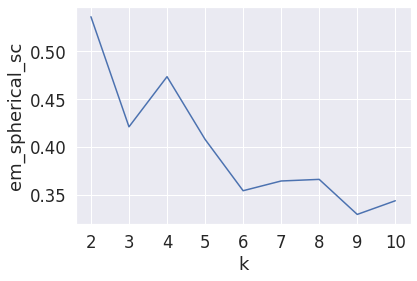

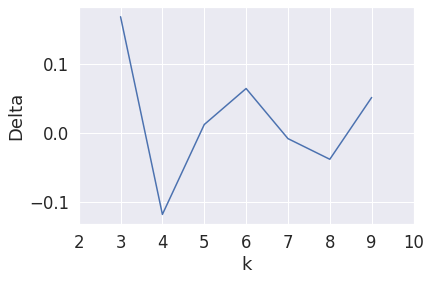

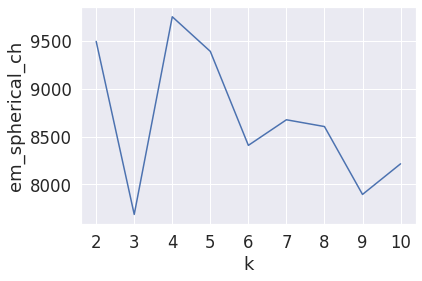

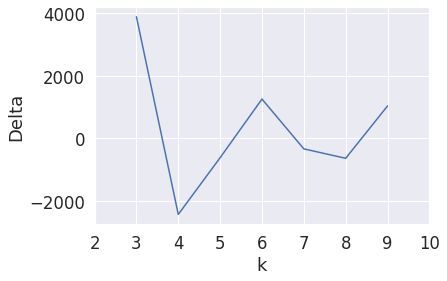

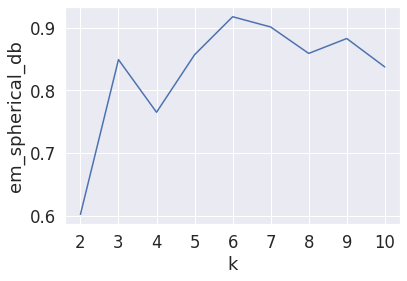

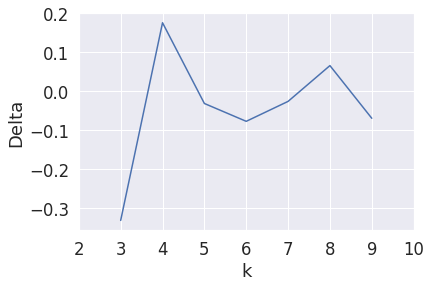

In [7]:
plot_measure(df_metricas.em_spherical_sc)
plot_delta(df_metricas.em_spherical_sc)
plot_measure(df_metricas.em_spherical_ch)
plot_delta(df_metricas.em_spherical_ch)
plot_measure(df_metricas.em_spherical_db)
plot_delta(df_metricas.em_spherical_db)

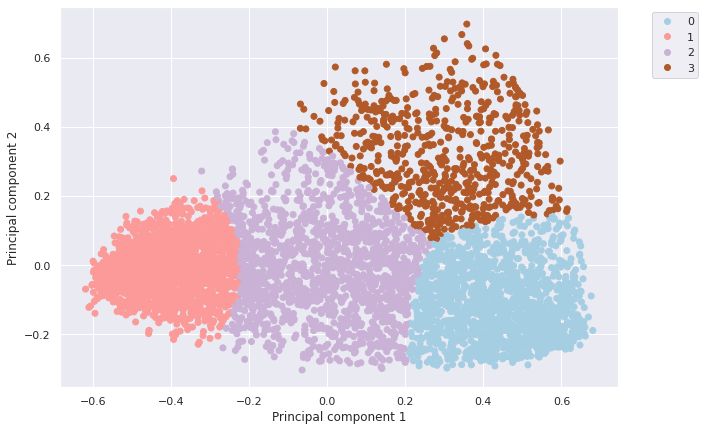

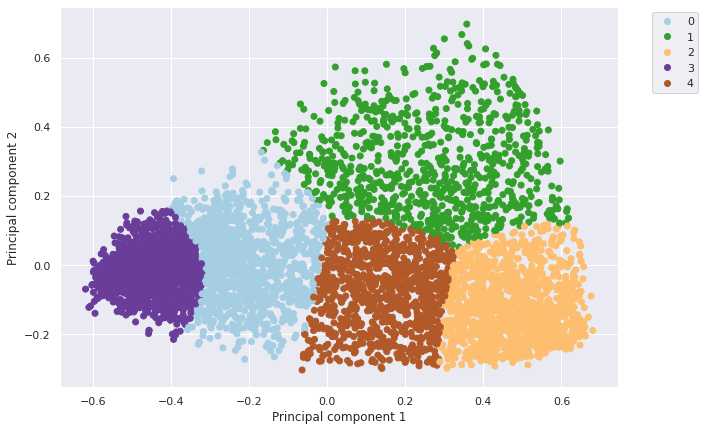

In [8]:
plot_clusters(df_dataset, df_y['4'])
plot_clusters(df_dataset, df_y['5'])

In [9]:
df_metricas[df_metricas.k == 5]

,k,em_spherical_sc,em_spherical_ch,em_spherical_db
3,5,0.408021,9392.58736,0.856803


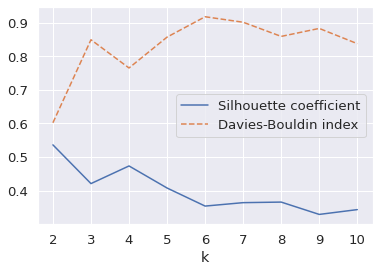

In [10]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(6,4))
sns.lineplot(x=df_metricas.k, y=df_metricas.em_spherical_sc, label='Silhouette coefficient')
sns.lineplot(x=df_metricas.k, y=df_metricas.em_spherical_db, label='Davies-Bouldin index', linestyle='--')
plt.xticks(df_metricas.k)
plt.ylabel(None)
plt.show()

412


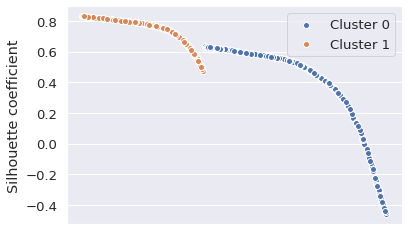

928


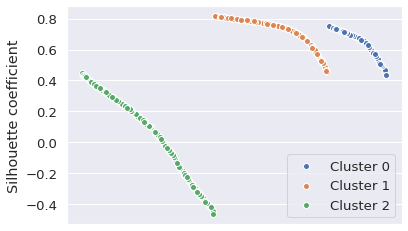

333


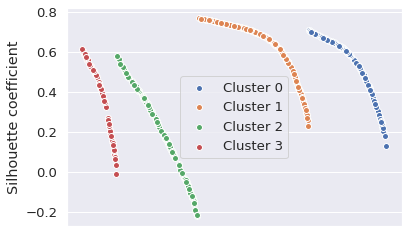

295


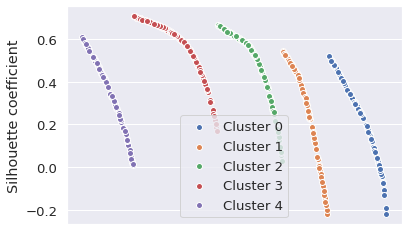

416


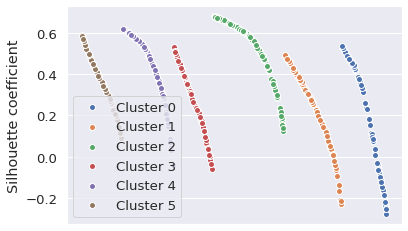

370


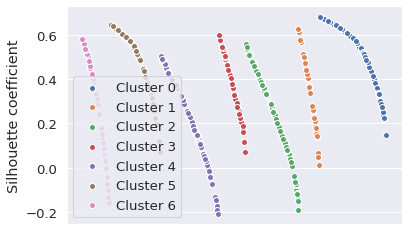

338


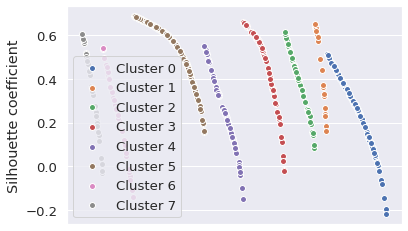

702


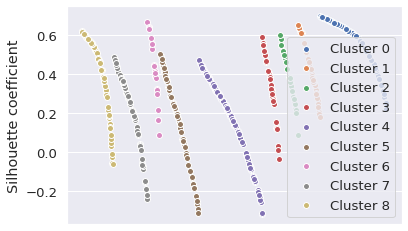

468


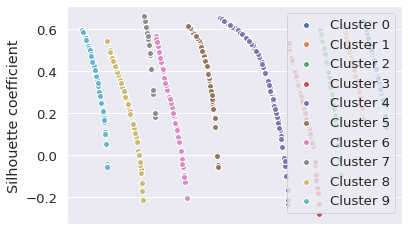

In [11]:
for k in range(2,11):
    k_string = str(k)
    sc = silhouette_samples(df_dataset, df_y[k_string])
    df_sc = df_dataset.copy()
    df_sc['cluster'] = df_y[k_string]
    df_sc['sc'] = sc
    df_sc = df_sc.sort_values(['cluster', 'sc'], ascending=False)
    df_sc = df_sc.reset_index()
    df_sc = df_sc[['cluster','sc']]
    df_sc['row'] = df_sc.index.astype(int)
    classificacoes_erradas = len(df_sc[df_sc.sc < 0])
    print(classificacoes_erradas)
    # fig = plt.figure(figsize=(6,4))
    fig, ax = plt.subplots(figsize=(6,4))
    for i in range(k):
        df = df_sc[df_sc.cluster == i]
        df = df.sample(int(len(df)*0.10))
        plt.scatter(df.row, df.sc, label='Cluster '+str(i), edgecolors='white')
    plt.xticks(None)
    plt.ylabel('Silhouette coefficient')
    # ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    plt.legend()
    plt.show()

In [12]:
df_sc

,cluster,sc,row
0,9,0.605708,0
1,9,0.605257,1
2,9,0.604797,2
3,9,0.603764,3
4,9,0.602772,4
...,...,...,...
5560,0,0.088357,5560
5561,0,0.081135,5561
5562,0,0.080147,5562
5563,0,0.073860,5563


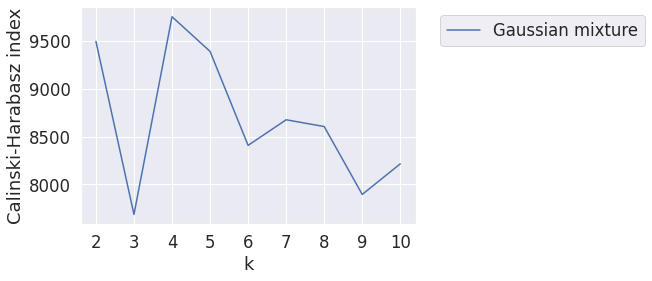

In [13]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(6,4))
sns.lineplot(x=df_metricas.k, y=df_metricas.em_spherical_ch, label='Gaussian mixture')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(df_metricas.k)
plt.ylabel('Calinski-Harabasz index')
plt.show()

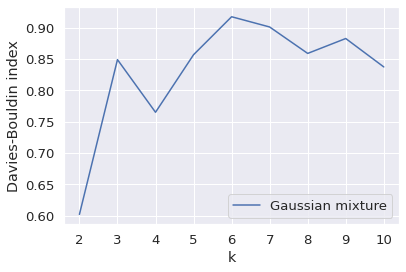

In [14]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(6,4))
sns.lineplot(x=df_metricas.k, y=df_metricas.em_spherical_db, label='Gaussian mixture')
plt.xticks(df_metricas.k)
plt.ylabel('Davies-Bouldin index')
plt.show()

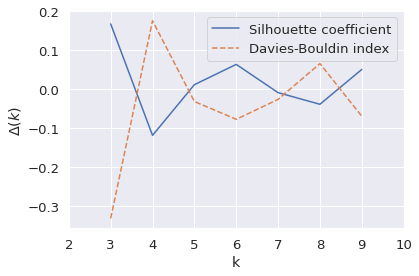

In [15]:
delta_sc = delta(df_metricas.em_spherical_sc)
delta_db = delta(df_metricas.em_spherical_db)
delta_ch = delta(df_metricas.em_spherical_ch)
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(6,4))
sns.lineplot(x=delta_sc.keys(), y=delta_sc.values(), label='Silhouette coefficient')
sns.lineplot(x=delta_db.keys(), y=delta_db.values(), label='Davies-Bouldin index', linestyle='--')
plt.xticks(df_metricas.k)
plt.xlabel('k')
plt.ylabel('$\Delta(k) $')
plt.show()

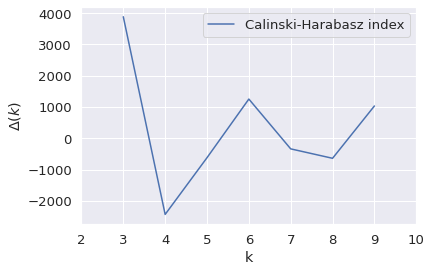

In [16]:
delta_sc = delta(df_metricas.em_spherical_sc)
delta_db = delta(df_metricas.em_spherical_db)
delta_ch = delta(df_metricas.em_spherical_ch)
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(6,4))
sns.lineplot(x=delta_ch.keys(), y=delta_ch.values(), label='Calinski-Harabasz index')
plt.xticks(df_metricas.k)
plt.xlabel('k')
plt.ylabel('$\Delta(k) $')
plt.show()

## Labeling the clusters (external analysis)

In [17]:
selected_attributes = ['PERCENTUAL_POPULACAO_0_A_5_ANOS',
          'PERCENTUAL_POPULACAO_6_A_14_ANOS',
          'PERCENTUAL_POPULACAO_15_A_24_ANOS',
          'PERCENTUAL_POPULACAO_25_A_39_ANOS',
          'PERCENTUAL_POPULACAO_40_A_59_ANOS',
          'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS',
         'PERCENTUAL_POPULACAO_URBANA',
         'IDHM_RENDA',
          'GINI',
          'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA',
         'TAXA_ATIVIDADE',
                       'PERCENTUAL_TRABALHADORES_INFORMAIS',
                       'PERCENTUAL_OCUPADOS_AGROPECUARIA',
                       'PERCENTUAL_OCUPADOS_COMERCIO',
                       'PERCENTUAL_OCUPADOS_SERVICO',
                       'PERCENTUAL_OCUPADOS_INDUSTRIA']

### k = 5 (valores médios)
 * Grupo (VS muito menor)
    * População mais urbana 87%
    * População mais economicamente ativa 61%
    * População mais ocupada nos setores de comércio 14%, serviço 38% e indústria 19%
 * Grupo (Rural com VS menor)
      * População mais idosa 15% + 60 anos
      * População mais economicamente ativa 65%
      * Mais trabalhadores informais 55%
 * Grupo (VS média)
     * População mais urbana 78%
     * População mais economicamente ativa 57%
     * População mais ocupada nos setores de comércio 12%, serviço 38% e indústria 12%
  * Grupo (VS maior)
      * População mais urbana 61%
      * População com renda mais baixa (idhm renda = 0,61 e BF = 156)
      * População com mais desigualdade de renda 0,51
      * Mais trabalhadores informais 65%
      * População mais ocupada nos setores de comércio 11% e serviço 33%
 * Grupo (VS muito maior)
      * População com renda mais baixa (idhm renda = 0,55 e BF = 289)
      * População com mais desigualdade de renda 0,54
      * Mais trabalhadores informais 76%



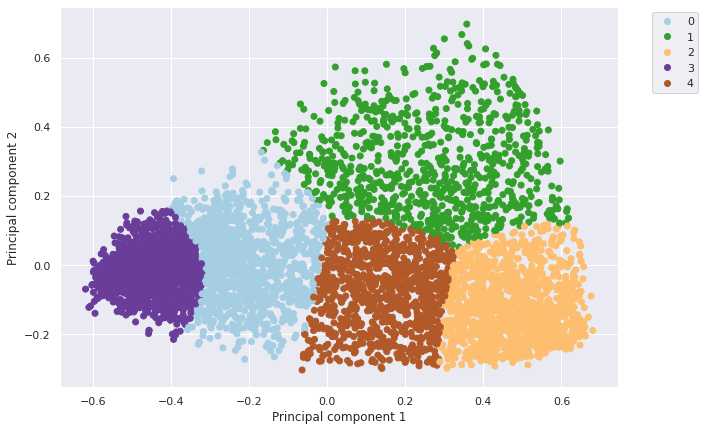

In [18]:
plot_clusters(df_dataset, df_y['5'])

In [19]:
df_base['k5'] = df_y['5']
df_base.loc[df_base.k5 == 0, 'k5_label'] = 'High SV'
df_base.loc[df_base.k5 == 1, 'k5_label'] = 'Rural with low SV'
df_base.loc[df_base.k5 == 2, 'k5_label'] = 'Very low SV'
df_base.loc[df_base.k5 == 3, 'k5_label'] = 'Very high SV'
df_base.loc[df_base.k5 == 4, 'k5_label'] = 'Intermediate SV'

labels_sorted = ['Very low SV','Rural with low SV', 'Intermediate SV', 'High SV', "Very high SV"]
categorical_type = CategoricalDtype(categories=labels_sorted, ordered=True)
df_base.k5_label = df_base.k5_label.astype(categorical_type)
df_base = df_base.sort_values('k5_label')

df_base.groupby('k5_label').describe()[selected_attributes]

PERCENTUAL_POPULACAO_0_A_5_ANOS                             \
                                            count       mean       std   min   
k5_label                                                                       
Very low SV                                1176.0   7.855162  1.072260  4.06   
Rural with low SV                           825.0   7.332848  1.465141  2.81   
Intermediate SV                             948.0   8.498333  1.431302  4.26   
High SV                                    1078.0   9.581651  1.755437  5.32   
Very high SV                               1538.0  10.808088  2.151116  6.76   

                                                   \
                      25%     50%      75%    max   
k5_label                                            
Very low SV        7.1575   7.765   8.5000  12.92   
Rural with low SV  6.4200   7.220   8.2800  13.04   
Intermediate SV    7.5100   8.355   9.3200  15.21   
High SV            8.3925   9.415  10.6300  18.49   
Very high SV       9.3300  10.340  11.7375  23.06   

                  PERCENTUAL_POPULACAO_6_A_14_ANOS             ...  \
                                             count       mean  ...   
k5_label                                                       ...   
Very low SV                                 1176.0  13.895672  ...   
Rural with low SV                            825.0  14.193697  ...   
Intermediate SV                              948.0  15.306973  ...   
High SV                                     1078.0  17.360510  ...   
Very high SV                                1538.0  19.061905  ...   

                  PERCENTUAL_OCUPADOS_SERVICO         \
                                          75%    max   
k5_label                                               
Very low SV                           43.6450  78.23   
Rural with low SV                     28.4100  48.29   
Intermediate SV                       42.4925  60.94   
High SV                               37.3300  60.76   
Very high SV                          33.3450  57.12   

                  PERCENTUAL_OCUPADOS_INDUSTRIA                              \
                                          count       mean        std   min   
k5_label                                                                      
Very low SV                              1176.0  19.003827  10.446323  0.00   
Rural with low SV                         825.0   8.309721   6.474354  0.14   
Intermediate SV                           948.0  11.524747   7.904571  0.78   
High SV                                  1078.0   6.514620   5.687788  0.00   
Very high SV                             1538.0   4.128270   3.688365  0.00   

                                                    
                       25%     50%      75%    max  
k5_label                                            
Very low SV        11.1200  17.505  24.5975  65.11  
Rural with low SV   3.7300   6.750  10.6800  42.08  
Intermediate SV     5.8275   9.100  15.1600  57.22  
High SV             2.7925   4.670   7.8975  41.54  
Very high SV        1.9100   3.085   4.8900  31.39  

[5 rows x 128 columns]

In [20]:
df_base.groupby('k5_label').describe()[['TAXA_ATIVIDADE']]

TAXA_ATIVIDADE                                               \
                           count       mean       std    min      25%     50%   
k5_label                                                                        
Very low SV               1176.0  61.399872  5.122535  31.58  58.2600  61.135   
Rural with low SV          825.0  65.321867  8.304942  35.73  59.5900  64.550   
Intermediate SV            948.0  56.601572  5.118433  26.93  53.6375  56.800   
High SV                   1078.0  51.681744  6.349353  27.82  47.8275  51.765   
Very high SV              1538.0  47.275507  7.117113  17.29  42.8825  47.700   

                                   
                       75%    max  
k5_label                           
Very low SV        64.0325  79.33  
Rural with low SV  71.1800  91.27  
Intermediate SV    59.7325  72.28  
High SV            55.6400  74.20  
Very high SV       51.9975  75.25

In [28]:
df_base[df_base.TAXA_ATIVIDADE >= df_base.TAXA_ATIVIDADE.quantile(0.95)][['k5_label', 'CODIGO_MUNICIPIO_6']].groupby('k5_label').count()

,CODIGO_MUNICIPIO_6
k5_label,
Very low SV,59
Rural with low SV,214
Intermediate SV,2
High SV,3
Very high SV,1


In [39]:
df_base[df_base.TAXA_ATIVIDADE < df_base.TAXA_ATIVIDADE.quantile(0.15)][['k5_label', 'CODIGO_MUNICIPIO_6']].groupby('k5_label').count()

,CODIGO_MUNICIPIO_6
k5_label,
Very low SV,2
Rural with low SV,11
Intermediate SV,25
High SV,178
Very high SV,619


In [30]:
df_base[df_base.PERCENTUAL_TRABALHADORES_INFORMAIS >= df_base.PERCENTUAL_TRABALHADORES_INFORMAIS.quantile(0.95)][['k5_label', 'CODIGO_MUNICIPIO_6']].groupby('k5_label').count()

,CODIGO_MUNICIPIO_6
k5_label,
Very low SV,0
Rural with low SV,4
Intermediate SV,1
High SV,32
Very high SV,242


In [34]:
df_base[df_base.PERCENTUAL_POPULACAO_15_A_24_ANOS >= df_base.PERCENTUAL_POPULACAO_15_A_24_ANOS.quantile(0.95)][['k5_label', 'CODIGO_MUNICIPIO_6']].groupby('k5_label').count()

,CODIGO_MUNICIPIO_6
k5_label,
Very low SV,11
Rural with low SV,2
Intermediate SV,19
High SV,57
Very high SV,191


In [35]:
df_base[df_base.PERCENTUAL_POPULACAO_25_A_39_ANOS >= df_base.PERCENTUAL_POPULACAO_25_A_39_ANOS.quantile(0.95)][['k5_label', 'CODIGO_MUNICIPIO_6']].groupby('k5_label').count()

,CODIGO_MUNICIPIO_6
k5_label,
Very low SV,160
Rural with low SV,7
Intermediate SV,86
High SV,21
Very high SV,5


In [36]:
df_base[df_base.PERCENTUAL_POPULACAO_URBANA >= df_base.PERCENTUAL_POPULACAO_URBANA.quantile(0.95)][['k5_label', 'CODIGO_MUNICIPIO_6']].groupby('k5_label').count()

,CODIGO_MUNICIPIO_6
k5_label,
Very low SV,212
Rural with low SV,0
Intermediate SV,60
High SV,3
Very high SV,4


In [37]:
df_base[df_base.PERCENTUAL_OCUPADOS_AGROPECUARIA >= df_base.PERCENTUAL_OCUPADOS_AGROPECUARIA.quantile(0.95)][['k5_label', 'CODIGO_MUNICIPIO_6']].groupby('k5_label').count()

,CODIGO_MUNICIPIO_6
k5_label,
Very low SV,0
Rural with low SV,123
Intermediate SV,0
High SV,29
Very high SV,127


In [38]:
df_base[df_base.PERCENTUAL_OCUPADOS_INDUSTRIA >= df_base.PERCENTUAL_OCUPADOS_INDUSTRIA.quantile(0.95)][['k5_label', 'CODIGO_MUNICIPIO_6']].groupby('k5_label').count()

,CODIGO_MUNICIPIO_6
k5_label,
Very low SV,209
Rural with low SV,15
Intermediate SV,40
High SV,14
Very high SV,2


In [21]:
df_base.describe()[selected_attributes]

,PERCENTUAL_POPULACAO_0_A_5_ANOS,PERCENTUAL_POPULACAO_6_A_14_ANOS,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_25_A_39_ANOS,PERCENTUAL_POPULACAO_40_A_59_ANOS,PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS,PERCENTUAL_POPULACAO_URBANA,IDHM_RENDA,GINI,TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA,TAXA_ATIVIDADE,PERCENTUAL_TRABALHADORES_INFORMAIS,PERCENTUAL_OCUPADOS_AGROPECUARIA,PERCENTUAL_OCUPADOS_COMERCIO,PERCENTUAL_OCUPADOS_SERVICO,PERCENTUAL_OCUPADOS_INDUSTRIA
count,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000
mean,9.037835,16.279238,17.867781,22.410354,22.317109,12.087829,63.826402,0.642873,0.494381,137.791635,55.377849,56.494471,35.554907,10.574906,32.458066,9.613930
std,2.117525,2.991521,1.903707,2.215080,3.977836,3.275977,22.041128,0.080662,0.066075,110.384567,9.240448,19.274995,18.255263,4.407001,8.889092,8.921682
min,2.810000,4.590000,10.410000,14.850000,9.040000,2.600000,4.178855,0.400000,0.280000,1.030000,17.290000,10.890000,0.060000,0.740000,8.500000,0.000000
25%,7.580000,14.070000,16.560000,20.940000,19.220000,9.910000,47.075908,0.572000,0.450000,47.240000,49.240000,40.230000,21.810000,7.250000,26.130000,3.330000
50%,8.760000,15.960000,17.800000,22.260000,22.460000,12.070000,64.663795,0.654000,0.490000,99.380000,55.640000,57.150000,36.450000,10.050000,31.890000,6.530000
75%,10.120000,18.260000,19.240000,23.780000,25.400000,14.160000,82.208864,0.707000,0.540000,214.780000,61.230000,73.680000,49.290000,13.450000,38.010000,13.310000
max,23.060000,29.360000,30.660000,49.700000,33.870000,29.380000,100.000000,0.891000,0.800000,690.830000,91.270000,97.030000,85.120000,36.570000,78.230000,65.110000


In [23]:
df_base[(df_base.REGIAO_METROPOLITANA == 1)]

,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,ESTADO,CODIGO_MUNICIPIO_7,POPULACAO_ESTIMADA,...,NIVEL_TAXA_OBITOS_2020,NIVEL_LABEL_TAXA_OBITOS_2020,NIVEL_TAXA_OBITOS_2021,NIVEL_LABEL_TAXA_OBITOS_2021,NIVEL_TAXA_OBITOS_2022,NIVEL_LABEL_TAXA_OBITOS_2022,componente_principal_1,componente_principal_2,k5,k5_label
5569,530010,DF,53,Centro-Oeste,DISTRITO FEDERAL,53001.0,1.0,Distrito Federal,5300108,3015268,...,1,High,0,Intermediate,2,Low,0.493688,-0.235839,2,Very low SV
3850,355240,SP,35,Sudeste,REGIAO METROPOLITANA DE CAMPINAS,35072.0,1.0,São Paulo,3552403,282441,...,1,High,1,High,0,Intermediate,0.515029,-0.254067,2,Very low SV
3851,355250,SP,35,Sudeste,ALTO DO TIETE,35011.0,1.0,São Paulo,3552502,297637,...,1,High,1,High,2,Low,0.407419,-0.244740,2,Very low SV
3855,355280,SP,35,Sudeste,MANANCIAIS,35013.0,1.0,São Paulo,3552809,289664,...,2,Very high,1,High,2,Low,0.418800,-0.268432,2,Very low SV
3811,354870,SP,35,Sudeste,GRANDE ABC,35015.0,1.0,São Paulo,3548708,838936,...,2,Very high,1,High,0,Intermediate,0.515230,-0.254601,2,Very low SV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,250460,PB,25,Nordeste,1ª REGIAO MATA ATLANTICA,25001.0,1.0,Paraíba,2504603,24670,...,0,Low,5,Low,2,Low,-0.430927,-0.128682,3,Very high SV
1307,250490,PB,25,Nordeste,1ª REGIAO MATA ATLANTICA,25001.0,1.0,Paraíba,2504900,17319,...,1,High,3,Very low,2,Low,-0.407751,-0.031748,3,Very high SV
1405,251290,PB,25,Nordeste,14ª REGIAO,25014.0,1.0,Paraíba,2512903,24176,...,1,High,5,Low,2,Low,-0.333742,-0.034864,3,Very high SV
1381,251120,PB,25,Nordeste,12ª REGIAO,25012.0,1.0,Paraíba,2511202,28458,...,1,High,3,Very low,2,Low,-0.341169,-0.026701,3,Very high SV


In [31]:
df_base[(df_base.REGIAO == 'Sudeste') & (df_base.k5_label == 'Rural with low SV')]

,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,ESTADO,CODIGO_MUNICIPIO_7,POPULACAO_ESTIMADA,...,NIVEL_TAXA_OBITOS_2020,NIVEL_LABEL_TAXA_OBITOS_2020,NIVEL_TAXA_OBITOS_2021,NIVEL_LABEL_TAXA_OBITOS_2021,NIVEL_TAXA_OBITOS_2022,NIVEL_LABEL_TAXA_OBITOS_2022,componente_principal_1,componente_principal_2,k5,k5_label
3600,352965,SP,35,Sudeste,JALES,35153.0,0.0,São Paulo,3529658,1908,...,0,Low,0,Intermediate,5,High,0.350967,0.094882,1,Rural with low SV
3799,354765,SP,35,Sudeste,JALES,35153.0,0.0,São Paulo,3547650,1545,...,2,Very high,4,Very high,3,Very low,0.450267,0.294814,1,Rural with low SV
3796,354740,SP,35,Sudeste,SANTA FE DO SUL,35152.0,0.0,São Paulo,3547403,2498,...,1,High,2,Extremely high,3,Very low,0.528523,0.135735,1,Rural with low SV
3794,354720,SP,35,Sudeste,JALES,35153.0,0.0,São Paulo,3547205,1487,...,3,Very low,1,High,1,Very high,0.458195,0.159808,1,Rural with low SV
3834,355080,SP,35,Sudeste,RIO PARDO,35143.0,0.0,São Paulo,3550803,12182,...,4,Intermediate,1,High,5,High,0.581941,0.134270,1,Rural with low SV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,320030,ES,32,Sudeste,SUL,32004.0,0.0,Espírito Santo,3200300,14601,...,1,High,5,Low,0,Intermediate,0.285223,0.309681,1,Rural with low SV
3886,355530,SP,35,Sudeste,FERNANDOPOLIS,35154.0,0.0,São Paulo,3555307,1727,...,3,Very low,4,Very high,1,Very high,0.391869,0.082258,1,Rural with low SV
3882,355495,SP,35,Sudeste,BRAGANCA,35071.0,0.0,São Paulo,3554953,6894,...,4,Intermediate,1,High,5,High,0.310672,0.135571,1,Rural with low SV
3876,355460,SP,35,Sudeste,OURINHOS,35094.0,0.0,São Paulo,3554607,2658,...,4,Intermediate,1,High,4,Extremely high,0.175070,0.140751,1,Rural with low SV


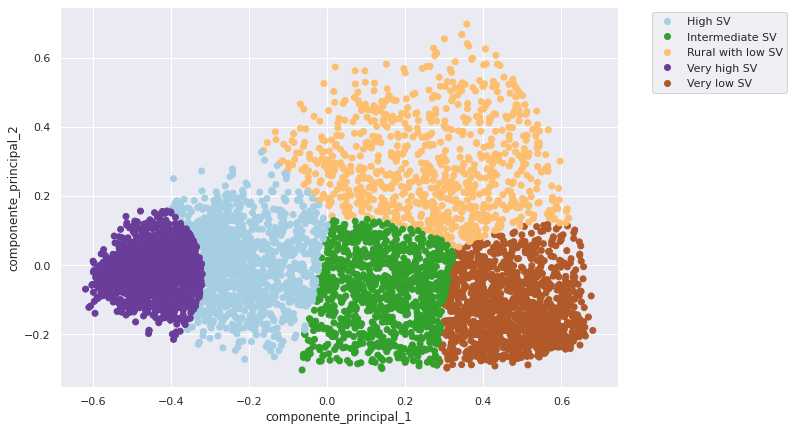

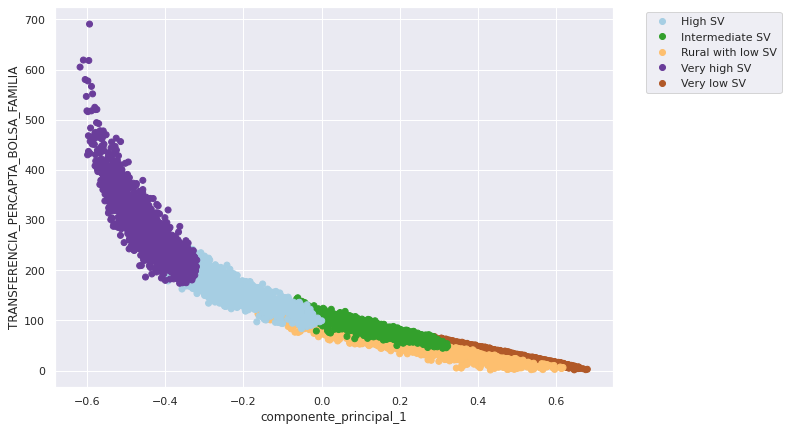

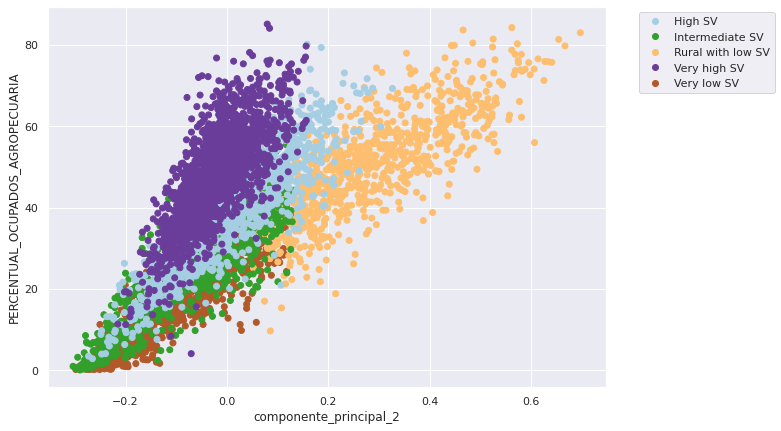

In [22]:
plot_clusters_original_attributes(df_base.componente_principal_1, df_base.componente_principal_2, df_base.k5_label)
plot_clusters_original_attributes(df_base.componente_principal_1, df_base.TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA, df_base.k5_label)
plot_clusters_original_attributes(df_base.componente_principal_2, df_base.PERCENTUAL_OCUPADOS_AGROPECUARIA, df_base.k5_label)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


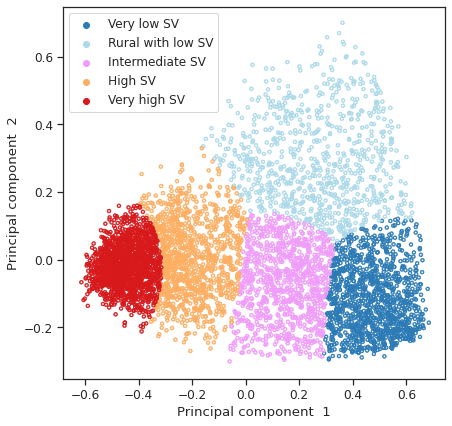

In [23]:
sns.set(font_scale=1.1)
sns.set_style("ticks")
sns.set_palette(get_default_colors_categorical_seaborn(5))

fig, ax = plt.subplots(figsize=(centimeter_to_inch(17.4), centimeter_to_inch(17.4)))
grafico = sns.scatterplot(x=df_base.componente_principal_1, y=df_base.componente_principal_2, hue=df_base.k5_label, marker="$\circ$", ec="face")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
plt.legend(loc='best')
plt.xlabel('Principal component  1')
plt.ylabel('Principal component  2')
plt.savefig('images/scatter_clusters.eps', bbox_inches="tight")
plt.savefig('images/scatter_clusters.pdf', bbox_inches="tight")
plt.savefig('images/scatter_clusters.png', bbox_inches="tight")
plt.show()

## Saving data

In [24]:
df_base.to_csv('data/df_labeled_risk_factors.csv', index=True)

In [27]:
df_base.groupby('k5_label').count()['CODIGO_MUNICIPIO_6']

k5_label
Very low SV          1176
Rural with low SV     825
Intermediate SV       948
High SV              1078
Very high SV         1538
Name: CODIGO_MUNICIPIO_6, dtype: int64

In [28]:
df_base.groupby('k5_label').sum()[['POPULACAO_2022']]/df_base.POPULACAO_2022.sum()*100

,POPULACAO_2022
k5_label,
Very low SV,53.631296
Rural with low SV,2.999760
Intermediate SV,21.359897
High SV,9.999278
Very high SV,12.009769


In [29]:
df_base.POPULACAO_2022.sum()

203004607

In [30]:
df_base[(df_base.REGIAO_METROPOLITANA == 1)]

,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,ESTADO,CODIGO_MUNICIPIO_7,POPULACAO_ESTIMADA,...,NIVEL_TAXA_OBITOS_2020,NIVEL_LABEL_TAXA_OBITOS_2020,NIVEL_TAXA_OBITOS_2021,NIVEL_LABEL_TAXA_OBITOS_2021,NIVEL_TAXA_OBITOS_2022,NIVEL_LABEL_TAXA_OBITOS_2022,componente_principal_1,componente_principal_2,k5,k5_label
5569,530010,DF,53,Centro-Oeste,DISTRITO FEDERAL,53001.0,1.0,Distrito Federal,5300108,3015268,...,0,High,1,Intermediate,5,Low,0.493688,-0.235839,2,Very low SV
3850,355240,SP,35,Sudeste,REGIAO METROPOLITANA DE CAMPINAS,35072.0,1.0,São Paulo,3552403,282441,...,0,High,2,High,2,Intermediate,0.515029,-0.254067,2,Very low SV
3851,355250,SP,35,Sudeste,ALTO DO TIETE,35011.0,1.0,São Paulo,3552502,297637,...,0,High,2,High,5,Low,0.407419,-0.244740,2,Very low SV
3855,355280,SP,35,Sudeste,MANANCIAIS,35013.0,1.0,São Paulo,3552809,289664,...,4,Very high,2,High,5,Low,0.418800,-0.268432,2,Very low SV
3811,354870,SP,35,Sudeste,GRANDE ABC,35015.0,1.0,São Paulo,3548708,838936,...,4,Very high,2,High,2,Intermediate,0.515230,-0.254601,2,Very low SV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,250460,PB,25,Nordeste,1ª REGIAO MATA ATLANTICA,25001.0,1.0,Paraíba,2504603,24670,...,2,Intermediate,4,Low,5,Low,-0.430927,-0.128682,3,Very high SV
1307,250490,PB,25,Nordeste,1ª REGIAO MATA ATLANTICA,25001.0,1.0,Paraíba,2504900,17319,...,0,High,0,Very low,5,Low,-0.407751,-0.031748,3,Very high SV
1405,251290,PB,25,Nordeste,14ª REGIAO,25014.0,1.0,Paraíba,2512903,24176,...,0,High,4,Low,5,Low,-0.333742,-0.034864,3,Very high SV
1381,251120,PB,25,Nordeste,12ª REGIAO,25012.0,1.0,Paraíba,2511202,28458,...,4,Very high,0,Very low,5,Low,-0.341169,-0.026701,3,Very high SV


In [31]:
df_base.median()[['PERCENTUAL_POPULACAO_URBANA','PERCENTUAL_POPULACAO_15_A_24_ANOS', 'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'PERCENTUAL_OCUPADOS_AGROPECUARIA', 'PERCENTUAL_OCUPADOS_COMERCIO','PERCENTUAL_OCUPADOS_SERVICO','PERCENTUAL_OCUPADOS_INDUSTRIA']]

PERCENTUAL_POPULACAO_URBANA             64.663795
PERCENTUAL_POPULACAO_15_A_24_ANOS       17.800000
TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA    99.380000
PERCENTUAL_OCUPADOS_AGROPECUARIA        36.450000
PERCENTUAL_OCUPADOS_COMERCIO            10.050000
PERCENTUAL_OCUPADOS_SERVICO             31.890000
PERCENTUAL_OCUPADOS_INDUSTRIA            6.530000
dtype: float64

In [32]:
df_base[(df_base.k5_label == 'Rural with low SV')].groupby('REGIAO').count()

,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,ESTADO,CODIGO_MUNICIPIO_7,POPULACAO_ESTIMADA,DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO,...,NIVEL_TAXA_OBITOS_2020,NIVEL_LABEL_TAXA_OBITOS_2020,NIVEL_TAXA_OBITOS_2021,NIVEL_LABEL_TAXA_OBITOS_2021,NIVEL_TAXA_OBITOS_2022,NIVEL_LABEL_TAXA_OBITOS_2022,componente_principal_1,componente_principal_2,k5,k5_label
REGIAO,,,,,,,,,,,,,,,,,,,,,
Centro-Oeste,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
Nordeste,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Norte,34,34,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,34
Sudeste,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
Sul,557,557,557,557,557,557,557,557,557,557,...,557,557,557,557,557,557,557,557,557,557
